# Water Closure Levels

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

In [7]:
bool_wb = xr.open_dataset(data_dir / "RUNOFF/bool_water_balance_20pct.nc")
bool_wb = bool_wb.to_array().isel(variable=0).drop("variable")
bool_wb

<xarray.DataArray (station_id: 671)>
array([False,  True, False, False,  True,  True, False, False, False,
        True, False, False, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  

# Read in AWS Models

In [8]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [9]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble_pet_trainperiod/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

# Fuse Data

In [10]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [11]:
fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [12]:
# import numpy as np 
# np.sqrt(0)

# Match Station / Times

In [13]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [14]:
import pickle

all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")
all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))
all_errors = pickle.load((data_dir / "RUNOFF/all_errors.pkl").open("rb"))


# Calculate Water Balances

In [15]:
def assign_wateryear(dt):
    """https://stackoverflow.com/a/52615358/9940782"""
    dt = pd.Timestamp(dt)
    if dt.month >= 10:
        return(pd.datetime(dt.year+1,1,1).year)
    else:
        return(pd.datetime(dt.year,1,1).year)
    

In [16]:
ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
# lstm_preds_wy = lstm_preds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in lstm_preds.time.values]))

In [244]:
from typing import List, Tuple, Optional


def create_closure_masks(
    ds: xr.Dataset,
    closure_thresholds: List[float] = [0.05, 0.1, 0.15, 0.2, 0.25],
    method: str = "sum",
) -> Tuple[xr.Dataset]:
    assert all([(c <= 1) & (c > 0) for c in closure_thresholds]), "Need to be between 0 and 1 (ratio)"
    # assign water year as a coordinate
    ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))

    # calculate water balance and mean precip
    if method == "sum":
        ann_aggregated = ds_wy.groupby("wy").sum().isel(wy=slice(1, -1))
    elif method == "mean":
        ann_aggregated = ds_wy.groupby("wy").mean().isel(wy=slice(1, -1))
    else: 
        assert False, "One of [sum, mean] required for calculating WaterYear WB"

    ann_closure = ann_aggregated["precipitation"] - ann_aggregated["pet"] - ann_aggregated["discharge_spec"]
    mean_closure = ann_closure.mean('wy')
    mean_precip = ann_aggregated["precipitation"].mean("wy")
    clos = mean_closure.to_dataframe("closure")["closure"]
    prec = mean_precip.to_dataframe("precip")["precip"]

    # calculate outside the error
    masks = []
    for c in closure_thresholds:
        # calculate the % of the precip marking the 'error'
        thresh = mean_precip * c
        ref_value_upper = 0.5 * thresh
        ref_value_lower = -0.5 * thresh

        # is it outside that epsilon error?
        bool_wb = ((clos > ref_value_upper.values) | (clos < ref_value_lower.values)).rename("mask")
        # bool_wb = bool_wb.to_dataset(**dict(name="mask"))
        bool_wb = bool_wb.to_xarray().assign_coords(threshold=c).expand_dims(dim="threshold")
        masks.append(bool_wb)

    threshold = xr.concat(masks, dim='threshold').to_dataset()
    
    return threshold, (mean_closure, mean_precip)

In [245]:
thresholds, (mean_closure, mean_precip) = create_closure_masks(ds, method="sum", closure_thresholds=[0.05, 0.1, 0.15, 0.2, 0.25])
thresholds = thresholds.sel(station_id=all_preds.station_id.values)

In [246]:
# plt.hist(mean_closure / mean_precip, density=True, bins=100)
# plt.gca().set_xlim(-1, 1)
# sns.despine()

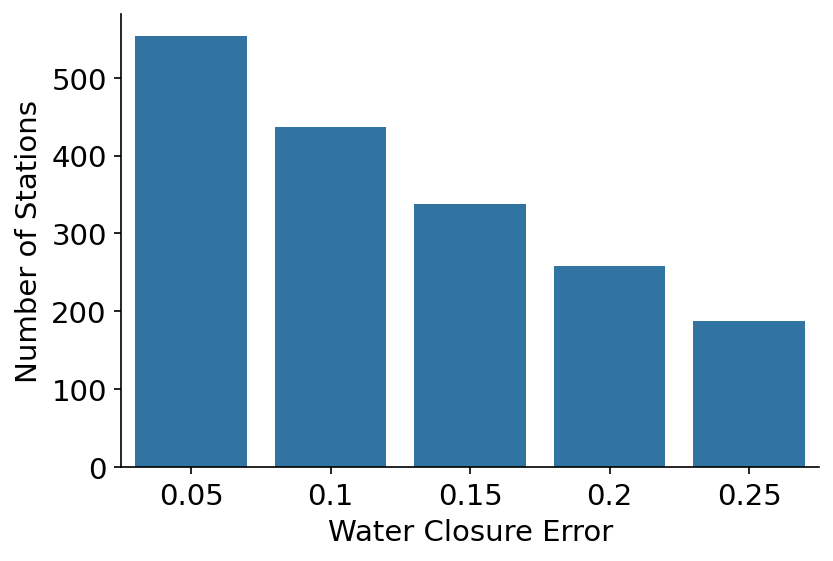

In [247]:
f, ax = plt.subplots()
sns.barplot(x="threshold", y="mask", data=threshold.sum("station_id").to_dataframe().reset_index(), color="C0")
ax.set_ylabel("Number of Stations")
ax.set_xlabel("Water Closure Error")
sns.despine()

# CDFs

In [248]:
from typing import Optional, List, Tuple

ml_sids = all_metrics["nse"].index.values

def plot_cdf(
    error_data, metric: str = "", 
    sids: List[int] = ml_sids, 
    clip: Optional[Tuple] = None, 
    ax = None, 
    title=None,
    models: Optional[List[str]] = None,
    median: bool = True,
    show_summary_stat: bool = True,
):
    colors = sns.color_palette()
    kwargs_dict = {
        "TOPMODEL": {"linewidth": 1, "alpha":0.8, "color": colors[2], "clip": clip},
        "PRMS": {"linewidth": 1, "alpha":0.8, "color": colors[3], "clip": clip},
        "ARNOVIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "VIC": {"linewidth": 1, "alpha":0.8, "color": colors[4], "clip": clip},
        "SACRAMENTO": {"linewidth": 1, "alpha":0.8, "color": colors[5], "clip": clip},
        "gr4j": {"linewidth": 1, "alpha":0.8, "color": colors[9], "clip": clip},
        "climatology": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_doy": {"linewidth": 1, "alpha":0.8, "color": colors[6], "clip": clip, "ls": "-."},
        "climatology_mon": {"linewidth": 1, "alpha":0.8, "color": colors[8], "clip": clip, "ls": "-."},
        "persistence": {"linewidth": 1, "alpha":0.8, "color": colors[7], "clip": clip, "ls": "-."},
        "EALSTM": {"linewidth": 3, "alpha": 1, "color": colors[1], "clip": clip},
        "LSTM": {"linewidth": 3, "alpha": 1, "color": colors[0], "clip": clip},
    }
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    
    if models is None:
        models = [c for c in error_data.columns if c in kwargs_dict]
    for ix, model in enumerate(models):
        summary_stat = error_data[model].dropna().median() if median else error_data[model].dropna().mean()
        sns.kdeplot(
            error_data[model].dropna(),
            cumulative=True,
            legend=False, ax=ax,
            label=f"{model}: {summary_stat:.2f}",
            **kwargs_dict[model]
        )
        if show_summary_stat:
            ax.axvline(summary_stat, ls="--", color=kwargs_dict[model]["color"])

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = title if title is not None else f"Cumuluative Density Function of Station {metric} Scores"
    ax.set_title(title)
    sns.despine()
    plt.legend()
    
    return ax

In [249]:
thresholds

<xarray.Dataset>
Dimensions:     (station_id: 518, threshold: 5)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 101005 102001 106001
  * threshold   (threshold) float64 0.05 0.1 0.15 0.2 0.25
Data variables:
    mask        (threshold, station_id) bool True False True ... False True True

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


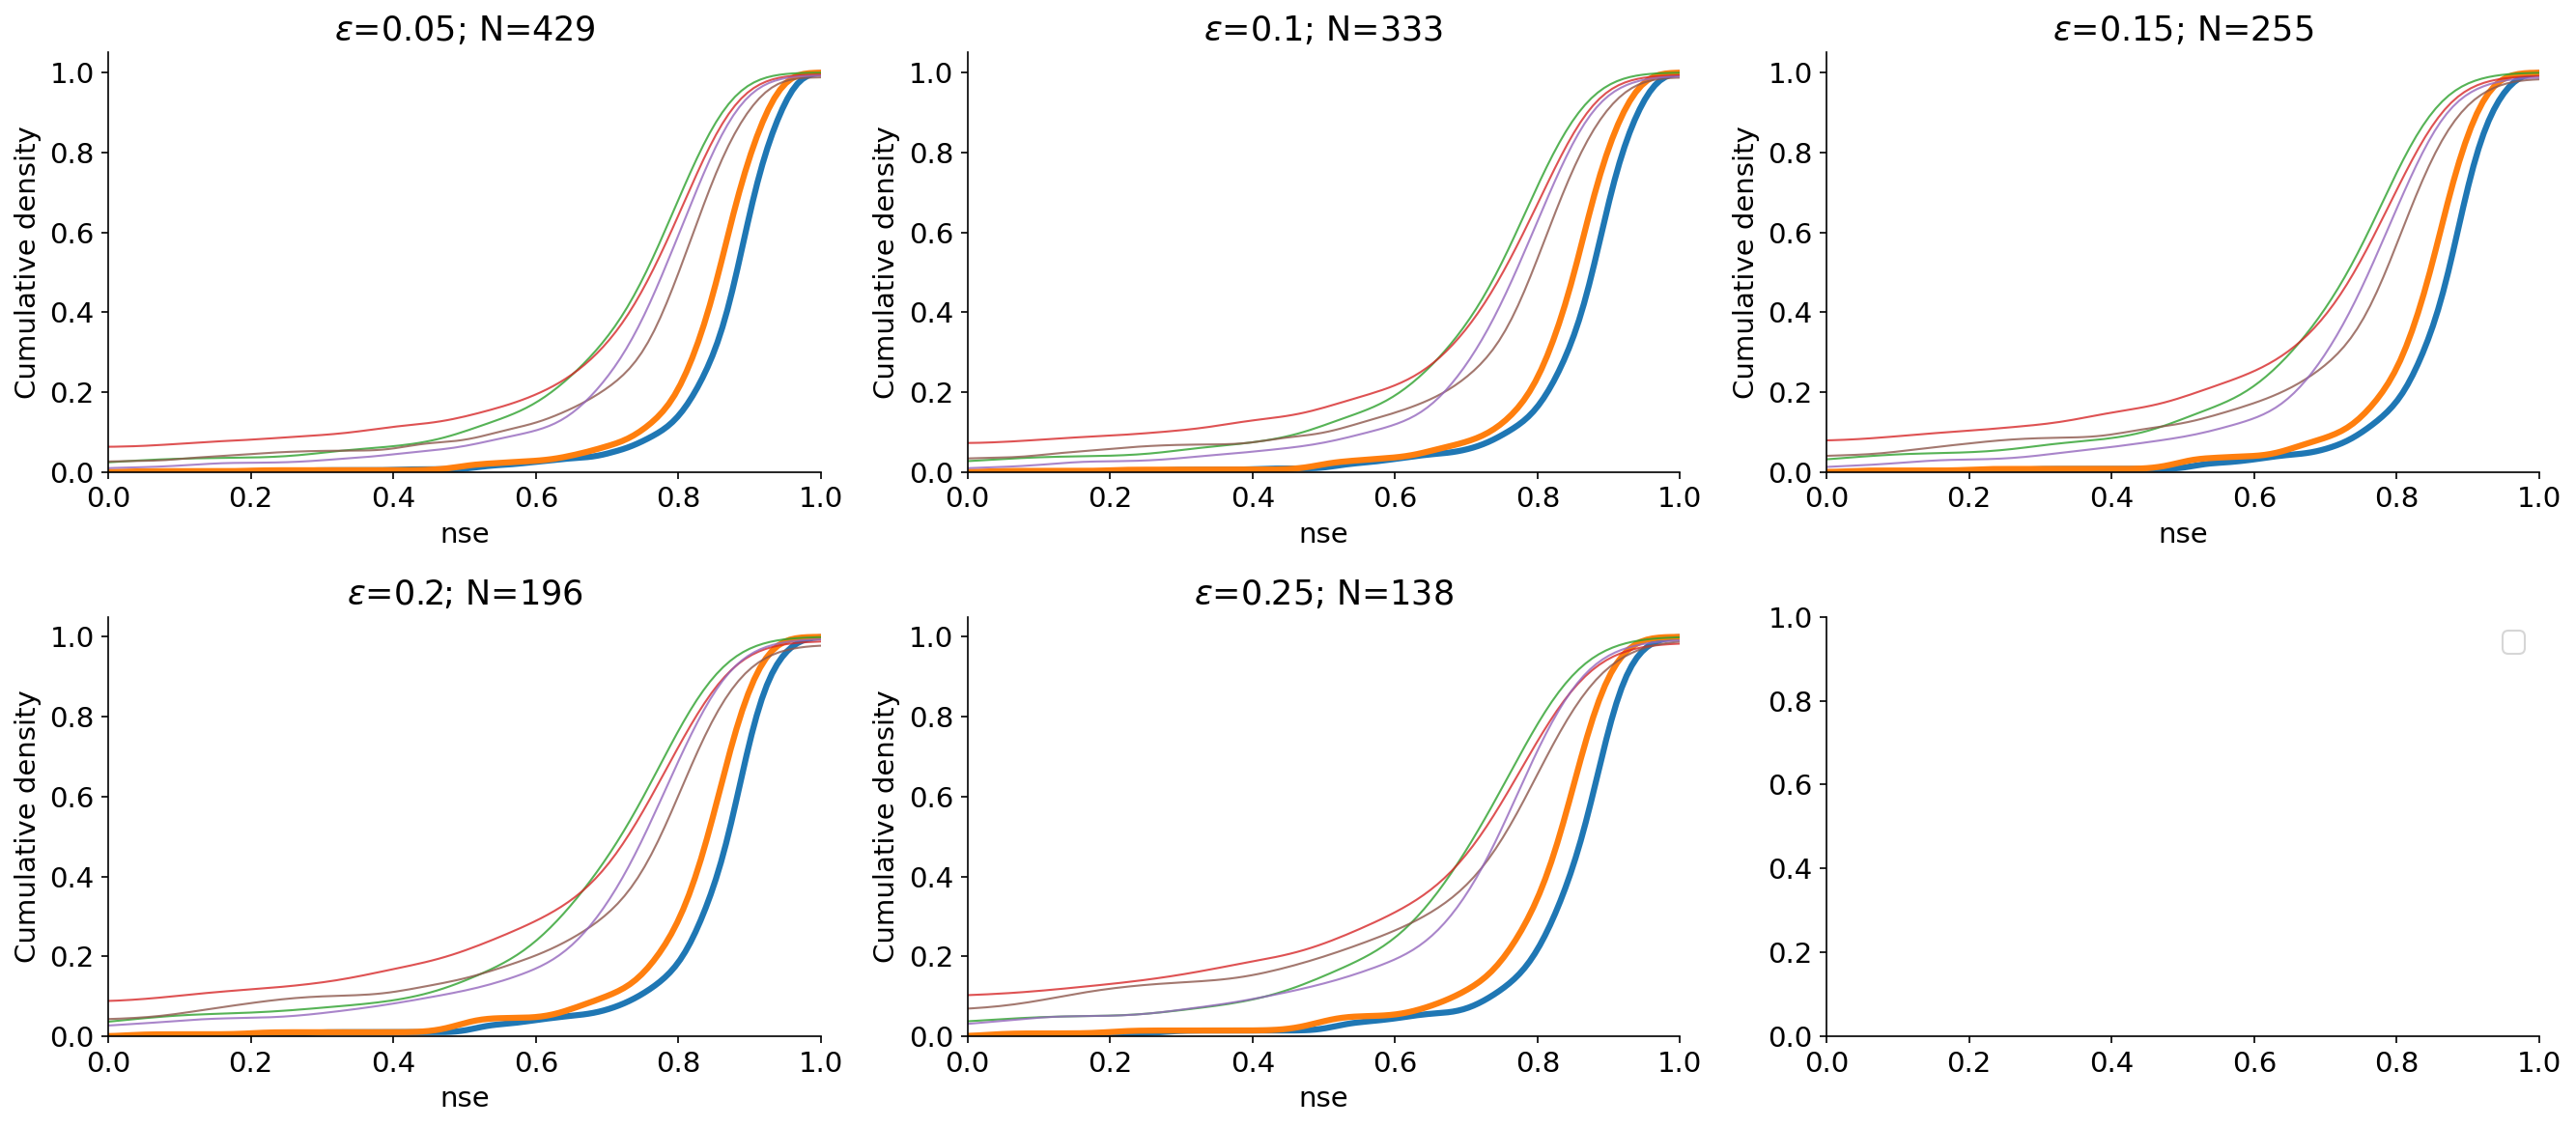

In [250]:
metric = "nse"
models = ["LSTM", "EALSTM", "TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
clip = (0, 1)
assert metric in all_metrics.keys()

f, axs = plt.subplots(2, 3, figsize=(6*3, 4*2))
thresh = thresholds.threshold.values[0]

for ix, thresh in enumerate(thresholds.threshold.values):
    condition_sids = thresholds.where(thresholds.sel(threshold=thresh)["mask"], drop=True).station_id.values
    ax = axs[np.unravel_index(ix, (2, 3))]
    plot_cdf(
        all_metrics[metric].loc[np.isin(all_metrics[metric].index, condition_sids), models],
        metric=metric, title="", ax=ax, clip=clip, median=False, show_summary_stat=False
    );
    ax.set_title(f"$\epsilon$={thresh}; N={len(condition_sids)}")
    if ax.get_legend() is not None:
        ax.get_legend().remove()

plt.tight_layout()

In [251]:
all_med = []
metric = "nse"

epsilon_dataframes = {}
for ix, thresh in enumerate(thresholds.threshold.values):
    condition_sids = thresholds.where(thresholds.sel(threshold=thresh)["mask"], drop=True).station_id.values
    
    # create table of median values
    metrics_to_summarise = all_metrics[metric].loc[np.isin(all_metrics[metric].index, condition_sids)]
    epsilon_dataframes[thresh] = metrics_to_summarise
    
    med = metrics_to_summarise.median()
    med = med.reset_index().rename({0: metric, "index": "Model"}, axis=1)
    med["$\epsilon$"] = thresh
    med = med.set_index(["$\epsilon$", "Model"])
    all_med.append(med) 
    
    
model_order = ['ARNOVIC', 'PRMS', 'SACRAMENTO', 'TOPMODEL', 'EALSTM', 'LSTM', ]
df = pd.concat(all_med).reset_index("Model").pivot_table(index=["$\epsilon$"], values=metric, columns=["Model"]).T.loc[model_order]
df

$\epsilon$,0.05,0.10,0.15,0.20,0.25
Model,,,,,
ARNOVIC,0.777014,0.768192,0.759787,0.752888,0.748128
PRMS,0.765775,0.751455,0.745363,0.738366,0.729612
SACRAMENTO,0.796766,0.789143,0.784983,0.781419,0.764892
TOPMODEL,0.760061,0.746885,0.739572,0.725353,0.708893
EALSTM,0.858841,0.855200,0.849627,0.845420,0.832771
LSTM,0.882259,0.879668,0.874850,0.872747,0.866690


In [252]:
from scipy.stats import wilcoxon, ks_2samp
from scripts.drafts.statistical_significance import _result_df

epsilon_significance = {}
ref_lookup = df.idxmax(axis=0)
for epsilon in df.columns:
    ref_model = ref_lookup.loc[epsilon]
    models = [m for m in df.index if m != ref_model]
    test_df = epsilon_dataframes[epsilon]
    
    epsilon_significance[epsilon] = _result_df(wilcoxon, metric_df=test_df, models=models, ref_model=ref_model)
    epsilon_significance[epsilon].loc["p0.01"] = (epsilon_significance[epsilon].loc["pvalue"] < 1 * 1e-2).astype(bool)
    epsilon_significance[epsilon].loc["n"] = len(test_df)
    epsilon_significance[epsilon].loc["ref_model"] = ref_model
    epsilon_significance[epsilon].loc["epsilon"] = epsilon
    epsilon_significance[epsilon] = epsilon_significance[epsilon]

In [253]:
all_tests = epsilon_significance

for key in all_tests.keys():
    print(f"{key} the best performing model significantly different for all:", all_tests[key].loc["p0.01"].sum() >= 5)
    if all_tests[key].loc["p0.01"].sum() == 4:
        for model in  all_tests[key].columns:
            print(f"\tIs significantly different for {model}", all_tests[key].loc["p0.01", key] == 1)

0.05 the best performing model significantly different for all: True
0.1 the best performing model significantly different for all: True
0.15 the best performing model significantly different for all: True
0.2 the best performing model significantly different for all: True
0.25 the best performing model significantly different for all: True


In [254]:
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
\$\textbackslash epsilon\$ &  0.05 &  0.10 &  0.15 &  0.20 &  0.25 \\
Model      &       &       &       &       &       \\
\midrule
ARNOVIC    &  0.78 &  0.77 &  0.76 &  0.75 &  0.75 \\
PRMS       &  0.77 &  0.75 &  0.75 &  0.74 &  0.73 \\
SACRAMENTO &  0.80 &  0.79 &  0.78 &  0.78 &  0.76 \\
TOPMODEL   &  0.76 &  0.75 &  0.74 &  0.73 &  0.71 \\
EALSTM     &  0.86 &  0.86 &  0.85 &  0.85 &  0.83 \\
LSTM       &  0.88 &  0.88 &  0.87 &  0.87 &  0.87 \\
\bottomrule
\end{tabular}



# Do static features correlate with water balance closure ?

In [29]:
X = mean_closure.sel(station_id=all_metrics["nse"]["SACRAMENTO"].index)
Y = all_metrics["nse"]["LSTM"]

In [30]:
X

<xarray.DataArray (station_id: 518)>
array([ 2.77999535e+02,  1.89295349e+01,  3.93645581e+02,  2.34700000e+02,
       -1.40231395e+02,  1.13031860e+02,  6.44919767e+02,  6.93224419e+02,
       -2.19925581e+01,  1.78478605e+02, -2.26286977e+02,  4.57125581e+01,
        3.90595349e+01,  2.09780698e+02,  2.21036977e+02,  4.14232558e+01,
        4.61323023e+02, -3.42093023e+00,  1.10387674e+02, -6.94369767e+01,
        3.25041860e+01, -5.61620930e+01, -4.12032558e+01,  9.06623256e+01,
       -5.95183721e+01, -5.74795349e+01,  1.97302791e+02, -7.18651163e+00,
        1.98161860e+02,  1.86081395e+01, -3.80962791e+01, -4.42148837e+01,
       -1.95904651e+01,  5.66502326e+01, -1.16396512e+02,  6.78348837e+00,
        6.02304651e+01,  7.07843721e+02, -1.73420233e+02,  8.62658140e+01,
        1.42075814e+02,  1.34630698e+02,  6.76494884e+02,  2.86623721e+02,
       -7.96983721e+01, -7.57018605e+01,  2.80829070e+02, -2.21962791e+01,
        4.87544186e+01, -8.08958140e+01,  1.97245349e+02,  3.35649302e+02,
       -1.44079070e+01,  1.44373953e+02, -1.07234884e+01,  5.37710930e+02,
        2.61669767e+02, -2.68146512e+01,  8.26125581e+01,  1.69233721e+02,
        5.24465116e+00,  1.84879070e+01, -6.23604651e+00, -5.45062791e+01,
       -4.55904651e+01,  1.12363488e+02, -7.37251163e+01, -6.88462791e+01,
       -2.00430233e+01, -6.51497674e+01, -2.85851163e+01, -2.63267442e+01,
       -6.17953488e+01, -8.78272093e+01, -7.09611628e+01, -1.25031628e+02,
       -5.07467442e+01, -6.60941860e+01, -2.51409302e+01, -4.78402326e+01,
       -6.10246512e+01, -7.27530233e+01, -2.72313953e+01, -1.72988837e+02,
        7.03116279e+01, -5.52109302e+01,  1.34273488e+02, -9.03581395e+00,
       -2.85632558e+01,  2.93285814e+02, -1.83791860e+02, -1.42640465e+02,
       -1.16325581e+01,  9.24116279e+00,  6.50293023e+01,  2.46602326e+01,
       -4.04883721e+00, -3.54109302e+01, -1.01360698e+02,  1.04833256e+02,
       -8.56318605e+01, -5.80153488e+01, -9.86172093e+01,  2.60253488e+01,
       -1.37836977e+02,  7.29963023e+02, -1.02580465e+02, -5.61953488e+01,
       -3.03232558e+01, -1.05231860e+02, -1.26327907e+02, -7.37062791e+01,
        7.05076744e+01, -7.16809302e+01,  2.22813721e+02, -1.17621395e+02,
        1.98588140e+02,  1.44069302e+02,  3.92402326e+01,  1.99369302e+02,
        1.15555116e+02,  3.23267674e+02,  2.64377442e+02,  4.17114419e+02,
       -7.19672093e+01, -7.81316279e+01, -9.51616279e+01, -6.82988372e+01,
        3.28258140e+01, -5.52632558e+01, -9.92109302e+01,  2.77309302e+02,
       -8.63934884e+01, -1.08912326e+02, -1.71430698e+02, -4.14746512e+01,
        2.99067442e+01,  1.01130465e+02, -9.14520930e+01, -1.18429070e+02,
       -4.76702326e+01, -1.18835349e+02, -3.47186047e+00,  3.84730233e+01,
       -7.10755814e+01, -6.26483721e+01,  6.84418605e+00, -8.13186047e+00,
       -5.61116279e+01, -3.54119070e+02, -6.52276744e+01, -1.06710000e+02,
        1.53506977e+01, -2.18344186e+01, -1.59144419e+02,  9.13651163e+01,
        3.59032326e+02, -5.92016279e+01, -1.08443721e+02, -1.03692791e+02,
       -8.33460465e+01, -2.63862791e+01,  2.22762791e+01, -4.87953488e+01,
       -5.09255814e+00, -1.72855814e+01, -9.97846512e+01, -4.20746512e+01,
       -8.05113953e+01, -8.16316279e+01, -7.31416279e+01, -6.24604651e+01,
       -9.54816279e+01, -7.42148837e+01, -6.70209302e+01, -7.22574419e+01,
       -9.94751163e+01, -6.81513953e+01, -6.72844186e+01, -1.49260698e+02,
       -2.03432558e+01,  3.39306977e+01, -7.81409302e+01, -8.66016279e+01,
       -1.49780000e+02, -6.07976744e+01, -7.08560465e+01, -6.93662791e+01,
       -1.51279070e+01, -9.56313953e+01, -1.16060698e+02, -7.95383721e+01,
        7.24930233e+00,  3.52016279e+01, -1.09172791e+02, -8.03079070e+01,
       -1.06023488e+02, -1.45832558e+02, -2.52850930e+02, -1.11938605e+02,
       -9.20781395e+01, -9.64611628e+01, -1.56596512e+02, -1.18234186e+02,
       -8.04504651e+01, -1.61158372e+02, -1.25592093e+02, -9.67906977e+01,
       -8.80297674e+01, -1.16543953e+02,  2.87953488e+00,  7.84

In [31]:
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

In [32]:
X = StandardScaler().fit_transform(X.values.reshape(-1, 1))
Y = StandardScaler().fit_transform(Y.values.reshape(-1, 1))

spearmanr(X, Y)

SpearmanrResult(correlation=-0.07161697888545755, pvalue=0.1034977113335096)

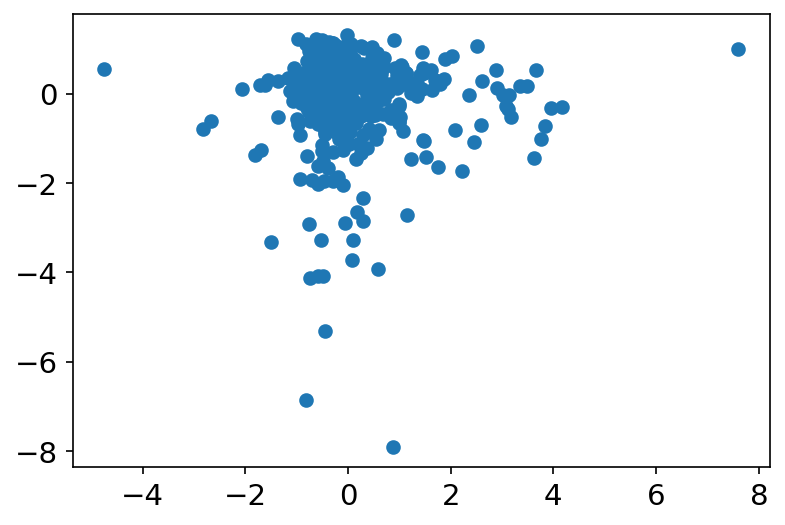

In [33]:
plt.scatter(X, Y)
# plt.gca().set_ylim(-1, 1)